# Profiles and Shapes

## Introduction

This tutorial is about generating custom 2d profiles using the geometry package. The process can be divided into 3 seperate steps.

- Create segments
- Create Shapes from segments
- Create a profile from multiple shapes

Each individual step will be discussed seperately.

Before we can start, we need to import some packages:

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np
import copy

import weldx.geometry as geo
import weldx.transformations as tf

Apart from some standard packages and the geometry module, we also import the transformation module. This is explained in detail in another tutorial, but the utilized functionality is rather self explanatory.

## Segments

Segments are small, 2-dimensional objects which define an elementary shape bounded by a starting point and an end point. Arbitrary shapes can be constructed with those basic entities. The simplest one is the line segment.

### Line segments

The  `LineSegment` class describes a straight line between 2 points in 2d space. It can be constructed using the class method 'construct_with_points':

In [3]:
line_segment_0 = geo.LineSegment.construct_with_points([0, 0], [1, 0])

It is also possible to create a line segment by calling its constructor directly. It requires a 2x2 matrix as input, where the first column contains the coordinates of the starting point and the second column the coordinates of the end point.

In [4]:
line_segment_1 = geo.LineSegment([[1, 0], [-1, -1]])

However, using the constructor directly might cause some confusion when just looking onto the code because of the way a matrix is defined. In the line above one can make the mistake and think the line segment is composed by the two points `[1, 0]` and `[-1, -1]`. But instead its points are  `[1, -1]` and `[0, -1]`, because each inner set of brackets define a row of the matrix (This convention is adapted from numpy) and the points are stored in columns. Keep that in mind or use the `construct_with_points` method exclusively.

### Rasterization

Each segment type has a 'rasterize' method which creates a set of data points that lie on the curve defined by the segment. The start and end point are always included. Additionally, all points have the same distance to each other. How large this distance is must be specified using the functions `raster_width` parameter. The data is returned in form of a 2xN matrix.

For a `LineSegment`, all data points are located on the connecting line between start and end point.

(-0.05, 1.05, -1.05, 0.05)

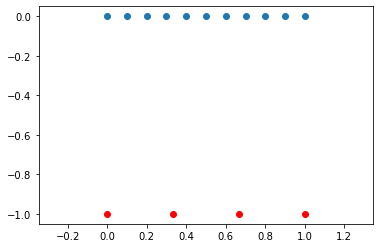

In [5]:
# rasterize both segments
data_line_segment_0 = line_segment_0.rasterize(0.1)
data_line_segment_1 = line_segment_1.rasterize(0.3)

# plot data
plt.plot(data_line_segment_0[0], data_line_segment_0[1], "o")
plt.plot(data_line_segment_1[0], data_line_segment_1[1], "ro")
plt.axis("equal")

In the above example we rasterized both segments using different `raster_width`. While it is possible to create a set of equidistant data points using `raster_width=0.1` for a line segment of length 1, it can not be done with `raster_width=0.3`. So the function calculates an effective raster width which is as close as possible to the specified one and uses this instead. For our example with `raster_width=0.3` the effective raster width is 1/3.

In case the raster width exceeds the length of the segment, it is automatically clipped to the segment length. In result, the data contains only the start and end point. Negative values or `0` will trigger an exception.

### Arc segments

Another default segment type is the `ArcSegment`. As the name suggests, it represents an arc between the defined start and end point. There are several ways to create an arc segment. The first one is using three points, the start and end point of the segment and the center point of the arc. The corresponding function is the `construct_with_points` method. It takes 4 parameters. The first 3 are the points. The fourth one is a bool which defines the winding order of the arc. If it is set to `True` the arc connects the start point to the end point using an counter clockwise arc. Otherwise both points are connected with a clockwise arc segment. This is shown in the following example, were we create two arc segment with identical points and their center point being the coordinate systems origin:

(-1.0999720781865128,
 1.0994136419167673,
 -1.0994136419167673,
 1.099972078186513)

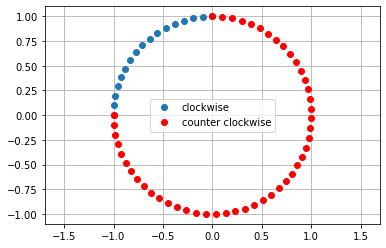

In [6]:
# create arc segments
arc_segment_0_cw = geo.ArcSegment.construct_with_points([-1, 0], [0, 1], point_center=[0, 0], arc_winding_ccw=False)
arc_segment_0_ccw = geo.ArcSegment.construct_with_points([-1, 0], [0, 1], point_center=[0, 0], arc_winding_ccw=True)

# rasterize segments
data_arc_segment_0_cw = arc_segment_0_cw.rasterize(0.1)
data_arc_segment_0_ccw = arc_segment_0_ccw.rasterize(0.1)

# plot data
plt.plot(data_arc_segment_0_cw[0], data_arc_segment_0_cw[1], 'o', label="clockwise")
plt.plot(data_arc_segment_0_ccw[0], data_arc_segment_0_ccw[1], 'ro', label="counter clockwise")
plt.grid()
plt.legend()
plt.axis("equal")

The provided center point must have the same distance to the start and the end point of the segment. Otherwise we would get an elliptical arch instead of an arc. If this condition is not fulfilled, an exception is raised.

Another method to construct an arc segment is to provide the segments start and end point and a radius. To do so, use the "construct_with_radius" method. It takes 5 parameters. The first to parameters are the segments start and end point. The third is the radius. Since there usually exist two possible center points with the same radius, the fourth parameter is a bool defining which center point should be selected. If `True`, the point to the left of the line connecting start and end point is selected. Otherwise the right point is selected. The fifth parameter determines the winding of the arc segment.

Here is a short example:

(-0.09997207818651273,
 2.099413641916767,
 -1.0994136419167673,
 1.0999720781865128)

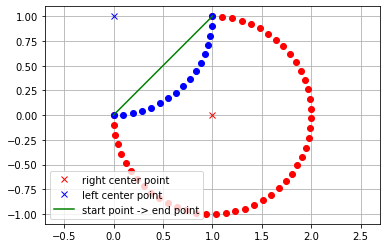

In [7]:
# create arc segments
arc_segment_1_rcp = geo.ArcSegment.construct_with_radius([0, 0], [1, 1], radius=1, center_left_of_line=False, arc_winding_ccw=True)
arc_segment_1_lcp = geo.ArcSegment.construct_with_radius([0, 0], [1, 1], radius=1, center_left_of_line=True, arc_winding_ccw=True)

# rasterize segments
data_arc_segment_1_rcp = arc_segment_1_rcp.rasterize(0.1)
data_arc_segment_1_lcp = arc_segment_1_lcp.rasterize(0.1)

# extract center points
center_point_right = arc_segment_1_rcp.point_center
center_point_left = arc_segment_1_lcp.point_center

# plot everything
plt.plot(data_arc_segment_1_rcp[0], data_arc_segment_1_rcp[1], "ro")
plt.plot(data_arc_segment_1_lcp[0], data_arc_segment_1_lcp[1], "bo")
plt.plot(center_point_right[0], center_point_right[1], "rx", label="right center point")
plt.plot(center_point_left[0], center_point_left[1], "bx", label="left center point")
plt.plot([0,1],[0,1], "g", label = "start point -> end point")
plt.grid()
plt.legend(loc="lower left")
plt.axis("equal")

As for the `LineSegment`, an `ArcSegment` can also be constructed using the class constructor. It takes a 2x3 matrix and a winding order as parameters, were the columns are start, end and center point. However, for the same reasons mentioned in the section about the `LineSegment`, it is better to use the "constuct" methods.

## Shape

The `Shape` class is a container class that stores multiple segments and ensures that they are connected to each other. The start point of a segment must always be identical to the end point of the previous segment, if it is not the first. If you try to add a segment which does not fulfill this requirement, an exception is raised.

The class constructor takes a single segment or a list of segments as parameter. You can also provide an empty list or no parameter at all, which results in an empty `Shape`. You can also always add more segments using the `add_segments` function. As for the constructor, you can provide single segments or lists of segments:

In [8]:
# create some segments
segment_0 = geo.LineSegment.construct_with_points([0,0], [0,1])
segment_1 = geo.LineSegment.construct_with_points([0,1], [1,1])
segment_2 = geo.ArcSegment.construct_with_points([1,1], [3,1], point_center=[2,1], arc_winding_ccw=False)
segment_3 = geo.LineSegment.construct_with_points([3,1], [4,1])
segment_4 = geo.LineSegment.construct_with_points([4,1], [4,0])
segment_5 = geo.LineSegment.construct_with_points([4,0], [0,0])


# create a shape
shape_0 = geo.Shape([segment_0, segment_1])

# add more segments to the shape
shape_0.add_segments(segment_2)              # single segment
shape_0.add_segments([segment_3, segment_4, segment_5]) # list of segments

Like the segments, the `Shape` class has a `rasterize` function, which works quite similar. Internally it just calls the `rasterize` methods of all its segments using the provided `raster_width` and returns the combined data. Because of this behaviour, the effective raster width may vary for each individual segment of the shape. An extreme example is to take a `raster_width` which is bigger than the length of the largest segment. Each segment will clip it to its own length and return just its start and end point:

(-0.2, 4.2, -0.09993582535855267, 2.0986523325296056)

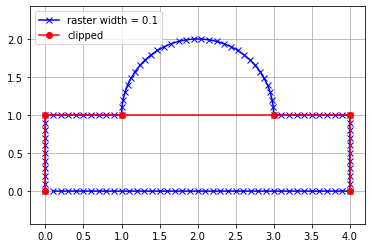

In [9]:
# rasterize shape with different raster width
shape_0_data = shape_0.rasterize(0.1)
shape_0_data_clipped = shape_0.rasterize(10000)

# plot data
plt.plot(shape_0_data[0], shape_0_data[1], 'bx-', label="raster width = 0.1")
plt.plot(shape_0_data_clipped[0], shape_0_data_clipped[1], 'ro-', label="clipped")
plt.grid()
plt.legend(loc="upper left")
plt.axis("equal")

Note that the shared points of the connected segments occur only once in the data array even though the rasterize methods of two neighboring segments both return their shared point. Additionally, the `Shape` recognizes that the first point of the first segment is identical to the last point of the last segment and includes it only once.
To be sure let's print the number of points of the clipped data, which must be 6 if no duplications occur:

In [10]:
print(shape_0_data_clipped.shape[1])

6


However, the shape does not generally filter duplications. If two segments have a common point which is not the first/last point of the shape and one or more segments were added between them, then this point will usually be included more than once. If this is a problem, you need to take care of that yourself by using `numpy.unique` or an equivalent function.

## Adding multiple line segments to a shape

So far, creating a `Shape` required us to generate all the segments in advance, which is a little bit tedious. Additionally, because all segments need to be connected to each other, a lot of points occur at least twice during the segments creation. By using the `add_line_segments` function of the `Shape`, it is no longer necessary to create line segments in advance.

The function takes a list of points and creates line segments from them, which are subsequently added to the `Shape`. The segments are created by traversing the list in ascending order and using the corresponding point as the segments end point. The start point is taken from the previous segment in the `Shape`. In case the `Shape` is empty, the first two points of the list are used to create the new segment:


(-0.05, 1.05, -0.07500000000000001, 1.575)

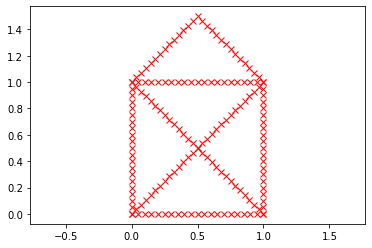

In [11]:
# create first 2 segments with an empty shape
shape_1 = geo.Shape()
shape_1.add_line_segments([[0, 0], [0, 1], [1, 1]])

# add 6 more segments to the existing shape
shape_1.add_line_segments([[0.5, 1.5], [0, 1], [1, 0], [0, 0], [1, 1], [1, 0]])

# rasterize data
data_shape_1 = shape_1.rasterize(0.05)

# plot
plt.plot(data_shape_1[0], data_shape_1[1], 'rx')
plt.axis("equal")

There is no equivalent function for arc segments. They can be constructed in different ways and during construction you need to provide more data than just the segments start and end point. Hence an "add_arc_segments" function would have a bloated and probably non-intuitive interface.

## Transformations

Consider you want to generate the shape of the previous example but rotated about a certain angle. Calculating the new position of the points and creating a new shape would be rather wearisome. Instead one can use shape's transformation functions. These are `translate`, `transform`, `apply_translation` and `apply_transformation`. The functions with the preceding "apply_" perform in-place transformations while the other ones return a transformed copy of the original object.

`translate` and `apply_translation` take a 2d vector as parameter. It defines the translation which is applied to every segment of the shape:


(-2.15, 1.15, -0.225, 4.725)

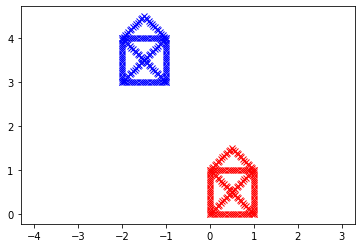

In [12]:
shape_2 = shape_1.translate([-2,3])

# rasterize data
data_shape_2 = shape_2.rasterize(0.05)

plt.plot(data_shape_1[0], data_shape_1[1], 'rx')
plt.plot(data_shape_2[0], data_shape_2[1], 'bx')
plt.axis("equal")

`transform` and `apply_transformation` expect a 2x2 transformation matrix as parameter, which is applied to all segments of the shape:

(-3.114775866404782,
 1.9628520777580993,
 -0.3497595264191645,
 7.344950054802455)

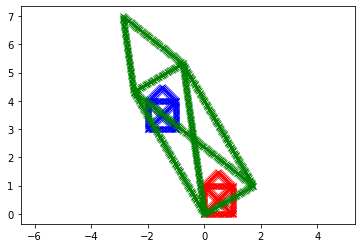

In [13]:
# create a transformation matrix which distorts and rotates the shape
angle = np.pi/6
s = np.sin(angle)
c = np.cos(angle)

distortion_matrix = np.array([[2, 0],[0,5]])
rotation_matrix = np.array([[c, -s], [s, c]])
transformation_matrix = np.matmul(rotation_matrix,distortion_matrix)

# get transformed shape
shape_3 = shape_1.transform(transformation_matrix)

# rasterize
data_shape_3 = shape_3.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx')
plt.plot(data_shape_2[0], data_shape_2[1], 'bx')
plt.plot(data_shape_3[0], data_shape_3[1], 'gx')
plt.axis("equal")

## Reflections

Since a lot of profiles consist of symmetric shapes, there is a `reflect` and a `apply_reflection` function. Similar to the other transformation functions `reflect` creates a reflected copy of the shape while `apply_reflection` modifies the original shape. These function perform a reflection across an arbitrary line. The first parameter of those functions is the normal of the line of reflection. The second parameter is optional and specifies the line of reflection's distance to the coordinate systems origin. The default distance is 0. Here are 3 examples:

(-1.1, 1.1, -1.15, 2.15)

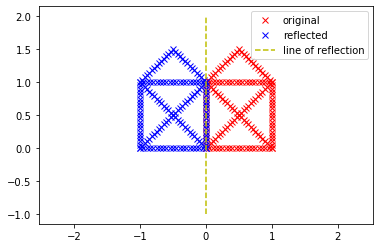

In [14]:
# reflect across the y axis
shape_4 = shape_1.reflect(reflection_normal=[1, 0])

# rasterize 
data_shape_4 = shape_4.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx', label="original")
plt.plot(data_shape_4[0], data_shape_4[1], 'bx', label="reflected")
plt.plot([0, 0], [-1, 2], 'y--', label="line of reflection")
plt.legend()
plt.axis("equal")

(-1.15, 2.15, -0.2, 4.2)

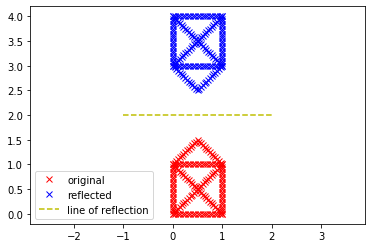

In [15]:
# reflect across the horizontal line with y = 2
shape_5 = shape_1.reflect(reflection_normal=[0, 1], distance_to_origin=2)

# rasterize 
data_shape_5 = shape_5.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx', label="original")
plt.plot(data_shape_5[0], data_shape_5[1], 'bx', label="reflected")
plt.plot([-1, 2], [2, 2], 'y--', label="line of reflection")
plt.legend(loc="lower left")
plt.axis("equal")

(-1.15, 2.15, -0.15000000000000002, 3.15)

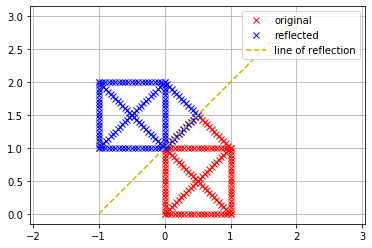

In [16]:
# reflect across a line with slope 1 containing the points (0,1) and (0.5, 1.5)
shape_6 = shape_1.reflect(reflection_normal=[-1, 1], distance_to_origin=1/np.sqrt(2))

# rasterize 
data_shape_6 = shape_6.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx', label="original")
plt.plot(data_shape_6[0], data_shape_6[1], 'bx', label="reflected")
plt.plot([-1, 2], [0, 3], 'y--', label="line of reflection")
plt.grid()
plt.legend(loc="upper right")
plt.axis("equal")

In the last example we wanted to reflect across a line that is not parallel to one of the coordinate systems axes. Providing the normal and distance to the origin gets a little bit more complicated for this case, since they aren't obvious anymore and need to be calculated. As an alternative to the previous ones, there also exist the methods `reflect_across_line` and `apply_reflection_across_line`. They perform a reflection across a line which is defined by its start and end point. Here is the alternative version of the previous example:

(-1.15, 2.15, -0.15000000000000002, 3.15)

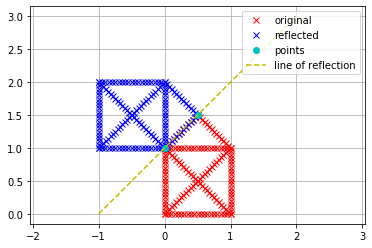

In [17]:
# reflect across a line with slope 1 containing the points (0,1) and (0.5, 1.5)
point_0 = [0, 1]
point_1 = [0.5, 1.5]
shape_7 = shape_1.reflect_across_line(point_0, point_1)

# rasterize 
data_shape_7 = shape_7.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx', label="original")
plt.plot(data_shape_7[0], data_shape_7[1], 'bx', label="reflected")
plt.plot([point_0[0], point_1[0]], [point_0[1], point_1[1]], 'co', label="points")
plt.plot([-1, 2], [0, 3], 'y--', label="line of reflection")
plt.grid()
plt.legend(loc="upper right")
plt.axis("equal")

Here is another example:

(-3.508243243243243, 2.2622972972972972, -4.8, 1.8)

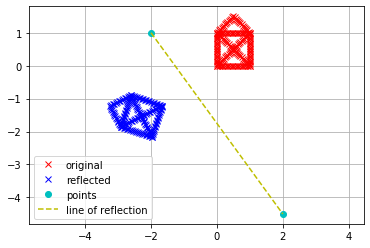

In [18]:
# reflect across a line with slope 1 containing the points (-2,1) and (2, -4.5)
point_0 = [-2, 1]
point_1 = [2, -4.5]
shape_8 = shape_1.reflect_across_line(point_0, point_1)

# rasterize 
data_shape_8 = shape_8.rasterize(0.05)

# plot all shapes
plt.plot(data_shape_1[0], data_shape_1[1], 'rx', label="original")
plt.plot(data_shape_8[0], data_shape_8[1], 'bx', label="reflected")
plt.plot([point_0[0], point_1[0]], [point_0[1], point_1[1]], 'co', label="points")
plt.plot([point_0[0], point_1[0]], [point_0[1], point_1[1]], 'y--', label="line of reflection")
plt.grid()
plt.legend(loc="lower left")
plt.axis("equal")

## Profiles

A `Profile` is a container class that stores multiple shapes. It represents the cross section of an assembly. One can add shapes to a `Profile` via its constructor or the `add_shapes` method. Both accept single shapes and lists of shapes. Like segments and the `Shape` class, a `Profile` also has a `rasterize` with identical functionality. Lets create a symmetric profile and rasterize it:

(-0.3500000000000001, 7.350000000000001, -1.1, 1.1)

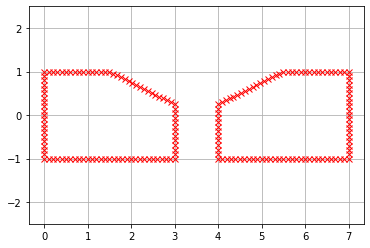

In [19]:
# create shapes
shape_9 = geo.Shape()
shape_9.add_line_segments([[0, 1], [1.5, 1], [3, 0.25], [3, -1], [0, -1], [0, 1]])
shape_10 = shape_9.reflect(reflection_normal=[1,0], distance_to_origin=3.5)

# create profile
profile_0 = geo.Profile(shape_9)
profile_0.add_shapes(shape_10)

# rasterize
data_profile_0 = profile_0.rasterize(0.1)

# plot
plt.plot(data_profile_0[0], data_profile_0[1], 'rx')
plt.grid()
plt.axis("equal")

That's already everything you need to know about profiles

## Custom segments

It might happen that lines and arcs are not enough to sufficiently describe a certain shape or profile. For this reason it is possible to define custom segment types. A segment which is useable with the `Shape` and `Profile` classes is a python class that needs at least a `rasterize` method and a `point_start` and `point_end` property. However, you want to use the Shapes transformation functions, you also need to define the segments `translate`, `transform`, `apply_translation` and `apply_transformation` functions. 

As a small example, we will create a sinusoidal wave segment. It should generate a sinusoidal wave in normal direction to the line from the segments start to its end. Since the start and end points must be included in the segments shape (otherwise we get visual gaps during rasterization) we can only use waves with wave lengths $N\pi$, were $N$ is the number half waves. Additionally we will add the option to vary the waves amplitude. The constructor of the class looks as follows:

~~~ python
    def __init__(self, point_start, point_end, num_half_waves, amplitude=1):
        self._points = np.array([point_start, point_end], float).transpose()
        self._num_half_waves = num_half_waves

        vector_start_end = self.point_end - self.point_start
        normal = np.array([-vector_start_end[1], vector_start_end[0]], float)

        self._amplitude_vector = np.ndarray((2, 1), float, tf.normalize(normal)) * amplitude
~~~

The points are stored as columns in a 2x2 matrix. Instead of storing the amplitude value itself, the normal to the vector `point_start`->`point_end` is calculated. Its length is adjusted so that it is equal to the amplitude. We call this vector `_amplitude_vector` and store it.
The reason for this is, that certain transformations (uneven scaling) distort the wave. As we will see later, this distortion can be memoized using the `_amplitude_vector`.

The implementation of  `point_start` and `point_end` properties should be self explanatory:

~~~ python
    @property
    def point_start(self):
        return self._points[:, 0]

    @property
    def point_end(self):
        return self._points[:, 1]
~~~

The last mandatory method a segment must provide is the `rasterize` method with a single parameter, the `raster_width`:

~~~ python
    def rasterize(self, raster_width):
        points_on_line = self._calculate_points_on_line(raster_width)
        offsets = self._calculate_offsets(points_on_line.shape[1] - 1)

        return points_on_line + offsets
~~~    

The implementation is split into 2 parts. First an equidistant set of points on the line `point_start`->`point_end` is generated. Afterwards the offset in direction of the `_amplitude_vector` are calculated and added. 

Note, that the point are not equidistant anymore, after the offset is applied. This is not consistent with the implementation of the `LineSegment` and the `ArcSegment`, but we want to keep things simple here.

The implementation of the function `_calculate_points_on_line` is:

~~~ python
    def _calculate_points_on_line(self, raster_width):
        # calculate distance between start and end point
        vector_start_end = self.point_end - self.point_start
        distance = np.linalg.norm(vector_start_end)

        # normalized effective raster width
        num_raster_segments = np.round(distance / raster_width)
        nerw = 1. / num_raster_segments
        
        # linear interpolation of the points
        weights = np.arange(0, 1 + 0.5 * nerw, nerw)
        weight_matrix = np.array([1 - weights, weights])
        return np.matmul(self._points, weight_matrix)
~~~

First, the length of the vector `point_start`->`point_end` is calculated. Using the specified `raster_width`, one can calculate how many points will fit into the raster. Afterwards, linear interpolation between start and end point is used.

The offsets are determined as follows:

~~~ python
    def _calculate_offsets(self, num_raster_segments):
        total_range = np.pi * self._num_half_waves
        increment = total_range / num_raster_segments
        
        angles = np.arange(0, total_range + 0.5 * increment, increment)
        return np.sin(angles) * self._amplitude_vector
~~~

It calculates the sine for each point multiplies it with the amplitude vector. Note that the points positions are not needed here, since we know that they areequidistant.

Here is the fully implemented class:

In [20]:
class SineWaveSegmentBase:
    def __init__(self, point_start, point_end, num_half_waves, amplitude=1):
        self._points = np.array([point_start, point_end], float).transpose()
        self._num_half_waves = num_half_waves

        vector_start_end = self.point_end - self.point_start
        normal = np.array([-vector_start_end[1], vector_start_end[0]], float)

        self._amplitude_vector = np.ndarray((2, 1), float, tf.normalize(normal)) * amplitude
        
    @property
    def point_start(self):
        return self._points[:, 0]

    @property
    def point_end(self):
        return self._points[:, 1]

    def _calculate_points_on_line(self, raster_width):
        # calculate distance between start and end point
        vector_start_end = self.point_end - self.point_start
        distance = np.linalg.norm(vector_start_end)

        # normalized effective raster width
        num_raster_segments = np.round(distance / raster_width)
        nerw = 1. / num_raster_segments
        
        # linear interpolation of the points
        weights = np.arange(0, 1 + 0.5 * nerw, nerw)
        weight_matrix = np.array([1 - weights, weights])
        return np.matmul(self._points, weight_matrix)

    def _calculate_offsets(self, num_raster_segments):
        total_range = np.pi * self._num_half_waves
        increment = total_range / num_raster_segments
        
        angles = np.arange(0, total_range + 0.5 * increment, increment)
        return np.sin(angles) * self._amplitude_vector

    def rasterize(self, raster_width):
        points_on_line = self._calculate_points_on_line(raster_width)
        offsets = self._calculate_offsets(points_on_line.shape[1] - 1)

        return points_on_line + offsets

        

Now we generate a shape, add an instance of this segment and rasterize it.

(-0.7939352559383557,
 10.513996916949445,
 -5.513996916949446,
 5.793935255938355)

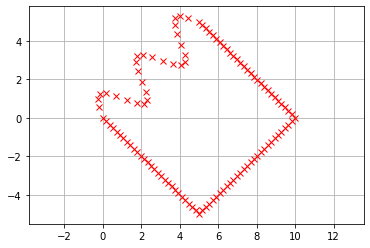

In [21]:
# create custom segment
sw_base_segment = SineWaveSegmentBase([0, 0], [5, 5], 5, 1)

# create a shape
shape_11 = geo.Shape(sw_base_segment)
shape_11.add_line_segments([[10, 0], [5, -5], [0, 0]])

# rasterize
data_shape_11 = shape_11.rasterize(0.25)


# plot data
plt.plot(data_shape_11[0], data_shape_11[1], 'rx')
plt.grid()
plt.axis("equal")

As you can see, we have successfully implemented our custom segment. 

If we want to apply transformations to the shape, we need to add the corresponding functionality to the segment type. We generate a new class which inherets from the `SineWaveSegmentBase`. Then we add the following functions, which perform "in-place" transformations:

~~~ python
def apply_translation(self, vector):
    self._points += np.ndarray((2, 1), float, np.array(vector, float))
    return self

def apply_transformation(self, matrix):
    self._points = np.matmul(matrix, self._points)
    self._amplitude_vector = np.matmul(matrix, self._amplitude_vector)
    return self
~~~

The translation is applied by adding the passed vector to the segments start and end point. A transformation is done by multiplying the `_points` matrix with the passed transformation matrix. Additionally, the `_amplitude_vector` must also be multiplied by the matrix.

We can use those 2 functions to add the other two functions that return a transformed copy:

~~~ python
    def translate(self, vector):
        new_segment = copy.deepcopy(self)
        return new_segment.apply_translation(vector)

    def transform(self, matrix):
        new_segment = copy.deepcopy(self)
        return new_segment.apply_transformation(matrix)
~~~

Here is the full class:

In [22]:
class SineWaveSegmentFull(SineWaveSegmentBase):
    def __init__(self, point_start, point_end, num_half_waves, amplitude=1):
        super().__init__(point_start, point_end, num_half_waves, amplitude)

    def apply_translation(self, vector):
        self._points += np.ndarray((2, 1), float, np.array(vector, float))
        return self

    def translate(self, vector):
        new_segment = copy.deepcopy(self)
        return new_segment.apply_translation(vector)

    def apply_transformation(self, matrix):
        self._points = np.matmul(matrix, self._points)
        self._amplitude_vector = np.matmul(matrix, self._amplitude_vector)
        return self

    def transform(self, matrix):
        new_segment = copy.deepcopy(self)
        return new_segment.apply_transformation(matrix)

Here are some examples that show that our implementation works:

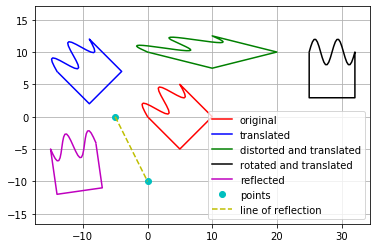

In [23]:
# create custom segment
sw_full_segment = SineWaveSegmentFull([0, 0], [5, 5], 4, 2)

# create a shape
shape_12 = geo.Shape(sw_full_segment)
shape_12.add_line_segments([[10, 0], [5, -5], [0, 0]])

# create translated copy
shape_13 = shape_12.translate([-14,7])

# create a distorted and translated copy
shape_14 = shape_12.transform([[2, 0], [0, 0.5]])
shape_14.apply_translation([0,10])      

# create a rotated and translated copy
s = np.sin(-np.pi / 4)
c = np.cos(-np.pi / 4)
shape_15 = shape_12.transform([[c, -s], [s, c]])
shape_15.apply_translation([25,10])      

# create a reflected copy
point_0 = [-5,0]
point_1 = [0,-10]
shape_16 = shape_12.reflect_across_line(point_0, point_1)


# rasterize
data_shape_12 = shape_12.rasterize(0.25)
data_shape_13 = shape_13.rasterize(0.25)
data_shape_14 = shape_14.rasterize(0.25)
data_shape_15 = shape_15.rasterize(0.25)
data_shape_16 = shape_16.rasterize(0.25)

# plot data
plt.plot(data_shape_12[0], data_shape_12[1], 'r', label="original")
plt.plot(data_shape_13[0], data_shape_13[1], 'b', label="translated")
plt.plot(data_shape_14[0], data_shape_14[1], 'g', label="distorted and translated")
plt.plot(data_shape_15[0], data_shape_15[1], 'k', label="rotated and translated")
plt.plot(data_shape_16[0], data_shape_16[1], 'm', label="reflected")
plt.plot([point_0[0], point_1[0]], [point_0[1], point_1[1]], 'co', label="points")
plt.plot([point_0[0], point_1[0]], [point_0[1], point_1[1]], 'y--', label="line of reflection")
plt.grid()
plt.axis("equal")
plt.legend(loc="lower right")